In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import re

%matplotlib inline

In [2]:
#Importing data
anime = pd.read_csv("data/anime_cleaned.csv")
anime

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,...,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme,duration_min,aired_from_year
0,11013,Inu x Boku SS,Inu X Boku Secret Service,妖狐×僕SS,Youko x Boku SS,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,...,Fridays at Unknown,"{'Adaptation': [{'mal_id': 17207, 'type': 'man...","Aniplex, Square Enix, Mainichi Broadcasting Sy...",Sentai Filmworks,David Production,"Comedy, Supernatural, Romance, Shounen","['""Nirvana"" by MUCC']","['#1: ""Nirvana"" by MUCC (eps 1, 11-12)', '#2: ...",24.0,2012.0
1,2104,Seto no Hanayome,My Bride is a Mermaid,瀬戸の花嫁,The Inland Sea Bride,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,Finished Airing,...,Unknown,"{'Adaptation': [{'mal_id': 759, 'type': 'manga...","TV Tokyo, AIC, Square Enix, Sotsu",Funimation,Gonzo,"Comedy, Parody, Romance, School, Shounen","['""Romantic summer"" by SUN&LUNAR']","['#1: ""Ashita e no Hikari (明日への光)"" by Asuka Hi...",24.0,2007.0
2,5262,Shugo Chara!! Doki,Shugo Chara!! Doki,しゅごキャラ！！どきっ,"Shugo Chara Ninenme, Shugo Chara! Second Year",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,51,Finished Airing,...,Unknown,"{'Adaptation': [{'mal_id': 101, 'type': 'manga...","TV Tokyo, Sotsu",NaN,Satelight,"Comedy, Magic, School, Shoujo","['#1: ""Minna no Tamago (みんなのたまご)"" by Shugo Cha...","['#1: ""Rottara Rottara (ロッタラ ロッタラ)"" by Buono! ...",24.0,2008.0
3,721,Princess Tutu,Princess Tutu,プリンセスチュチュ,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,38,Finished Airing,...,Fridays at Unknown,"{'Adaptation': [{'mal_id': 1581, 'type': 'mang...","Memory-Tech, GANSIS, Marvelous AQL",ADV Films,Hal Film Maker,"Comedy, Drama, Magic, Romance, Fantasy","['""Morning Grace"" by Ritsuko Okazaki']","['""Watashi No Ai Wa Chiisaikeredo"" by Ritsuko ...",16.0,2002.0
4,12365,Bakuman. 3rd Season,Bakuman.,バクマン。,Bakuman Season 3,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,25,Finished Airing,...,Unknown,"{'Adaptation': [{'mal_id': 9711, 'type': 'mang...","NHK, Shueisha",NaN,J.C.Staff,"Comedy, Drama, Romance, Shounen","['#1: ""Moshimo no Hanashi (もしもの話)"" by nano.RIP...","['#1: ""Pride on Everyday"" by Sphere (eps 1-13)...",24.0,2012.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6663,37405,Dokidoki Little Ooyasan,NaN,dokidokiりとる大家さん,NaN,https://myanimelist.cdn-dena.com/images/anime/...,OVA,Other,0,Currently Airing,...,NaN,[],NaN,NaN,Collaboration Works,Hentai,[],[],30.0,2018.0
6664,37886,Wo Shi Jiang Xiaobai (2018),I&#039;m Joybo OVA,我是江小白 小剧场,Wo Shi Jiang Xiao Bai: Xiao Ju Chang,https://myanimelist.cdn-dena.com/images/anime/...,ONA,Original,1,Finished Airing,...,NaN,"{'Prequel': [{'mal_id': 36775, 'type': 'anime'...",NaN,NaN,2:10 Animation,"Slice of Life, Drama, Romance",[],[],0.0,2018.0
6665,37255,Genki Genki Non-tan: Obake Mura Meiro,NaN,げんきげんきノンタン おばけむらめいろ,NaN,https://myanimelist.cdn-dena.com/images/anime/...,OVA,Original,1,Finished Airing,...,NaN,"{'Prequel': [{'mal_id': 25619, 'type': 'anime'...",NaN,NaN,Polygon Pictures,"Music, Kids",[],[],35.0,2015.0
6666,35229,Mr. Men Little Miss,Mr. Men Little Miss,Mr. Men Little Miss / ミスターメン リトルミス,NaN,https://myanimelist.cdn-dena.com/images/anime/...,ONA,Picture book,0,Currently Airing,...,NaN,[],NaN,NaN,Sanrio,Kids,[],[],2.0,2013.0


In [3]:
#Checking for nulls
print(anime.isna().sum())

anime_id              0
title                 0
title_english      3230
title_japanese        5
title_synonyms     2187
image_url             2
type                  0
source                0
episodes              0
status                0
airing                0
aired_string          0
aired                 0
duration              0
rating                0
score                 0
scored_by             0
rank                356
popularity            0
members               0
favorites             0
background         5855
premiered          3702
broadcast          3688
related               0
producer           2266
licensor           3881
studio                0
genre                 4
opening_theme         0
ending_theme          0
duration_min          0
aired_from_year       0
dtype: int64


In [4]:
#Data Cleaning

#Dropping nulls from genre
anime = anime.dropna(subset=['genre'])

#duplicates banished
anime = anime.drop_duplicates()

#dropping irrelevant or incomplete data
anime = anime.drop(['title_english', 'title_japanese', 'title_synonyms', 'image_url', 'related', 'opening_theme', 'ending_theme', 'status', 'airing', 'aired_string', 'aired', 'background', 'duration', 'rating', 'rank', 'favorites', 'premiered', 'broadcast', 'producer', 'licensor', 'popularity'], axis=1)
anime = anime[~anime['genre'].str.contains('hentai|yaoi|yuri', case=False)]

# drop all rows that contain a cell with the value of zero
anime = anime[(anime != 0).all(1)]

# create a new column named "watch_length" by multiplying "duration_min" and "episodes"
anime['watch_length'] = anime['duration_min'] * anime['episodes']

anime

,anime_id,title,type,source,episodes,score,scored_by,members,studio,genre,duration_min,aired_from_year,watch_length
0,11013,Inu x Boku SS,TV,Manga,12,7.63,139250,283882,David Production,"Comedy, Supernatural, Romance, Shounen",24.0,2012.0,288.0
1,2104,Seto no Hanayome,TV,Manga,26,7.89,91206,204003,Gonzo,"Comedy, Parody, Romance, School, Shounen",24.0,2007.0,624.0
2,5262,Shugo Chara!! Doki,TV,Manga,51,7.55,37129,70127,Satelight,"Comedy, Magic, School, Shoujo",24.0,2008.0,1224.0
3,721,Princess Tutu,TV,Original,38,8.21,36501,93312,Hal Film Maker,"Comedy, Drama, Magic, Romance, Fantasy",16.0,2002.0,608.0
4,12365,Bakuman. 3rd Season,TV,Manga,25,8.67,107767,182765,J.C.Staff,"Comedy, Drama, Romance, Shounen",24.0,2012.0,600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6657,37090,Hitori no Shita: The Outcast Recap,Special,Manga,1,6.04,181,1013,Haoliners Animation League,"Action, Super Power, Supernatural",24.0,2018.0,24.0
6658,36913,Inazuma Eleven x Kaitou Gru no Tsuki Dorobou,Special,Original,4,5.87,128,560,OLM,Comedy,0.2,2018.0,0.8
6662,37894,Ling Yu 4th Season,ONA,Novel,12,7.53,17,126,Haoliners Animation League,Fantasy,13.0,2016.0,156.0
6665,37255,Genki Genki Non-tan: Obake Mura Meiro,OVA,Original,1,4.20,5,37,Polygon Pictures,"Music, Kids",35.0,2015.0,35.0


In [5]:
#Importing data
#users = pd.read_csv("data/animelists_cleaned.csv")
#users

In [6]:
#Checking for correlation/multicolinearity

# Selecting columns with numerical values
numerical_columns = anime.select_dtypes(include=[np.number]).columns.tolist()

# Selecting the score column and calculating correlations with other columns
features = []
correlations = []
corr = anime[numerical_columns].corr()
for idx, correlation in corr['score'].iteritems():
    if correlation >= 0.3 and idx != 'score':
        features.append(idx)
        correlations.append(correlation)
corr_score_df = pd.DataFrame({'Features': features, 'Correlations': correlations})

# Checking for multicollinearity among the selected features
multicollinear_features = []
multicollinear_corr = []
def check_multicollinearity(feature):
    for idx, correlation in corr[feature].iteritems():
        if correlation >= 0.8 and idx != feature:
            multicollinear_features.append([feature, idx])
            multicollinear_corr.append(correlation)

for feature in numerical_columns:
    check_multicollinearity(feature)
mc_df = pd.DataFrame({'Features': [f[0] for f in multicollinear_features],
                      'Multicollinear_Features': [f[1] for f in multicollinear_features],
                      'Correlations': multicollinear_corr})

# Displaying the results
print('Features with Correlations to score')
display(corr_score_df)

print('Multicollinear Features')
display(mc_df)


Features with Correlations to score


,Features,Correlations
0,scored_by,0.394409
1,members,0.428485


Multicollinear Features


,Features,Multicollinear_Features,Correlations
0,episodes,watch_length,0.834427
1,scored_by,members,0.987091
2,members,scored_by,0.987091
3,watch_length,episodes,0.834427


In [8]:
#Dropping multicolinear faetures
anime = anime.drop('scored_by', axis=1)

#Dropping non-correlated variables
anime = anime.drop(['episodes', 'aired_from_year', 'duration_min', 'watch_length'], axis=1)

In [9]:
#Creating a list with the columns I'm using
num_cols = list(anime.drop(['anime_id', 'score'], axis=1).select_dtypes(include=['number']).columns)
predictors = pd.DataFrame({'Features': num_cols})
predictors

,Features
0,members


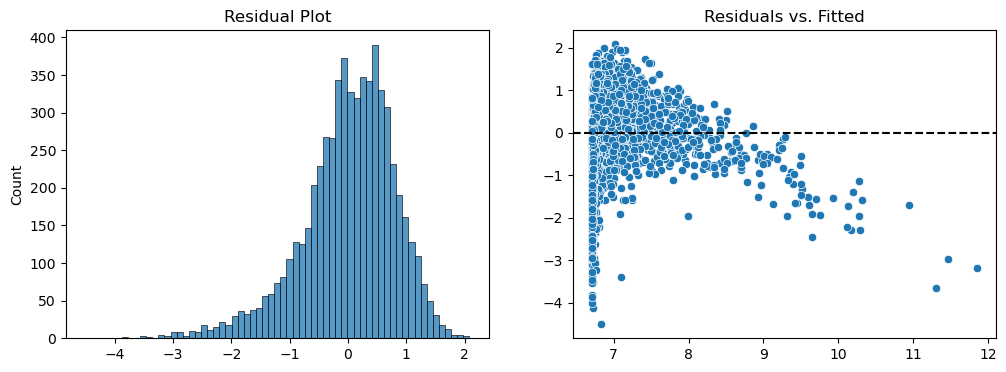

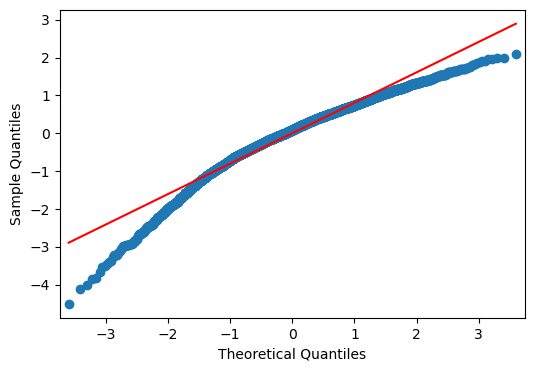

In [10]:
#Normality and homoscedacity check
# Fit simple linear regression model
model = smf.ols('score ~ ' + ' + '.join(predictors['Features']), data=anime).fit()

#Residual plot
resid = model.resid
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
sns.histplot(resid, ax=ax1)
ax1.set_title('Residual Plot')
#Scatter Plot
sns.scatterplot(x=model.predict(), y=resid, ax=ax2)
ax2.axhline(0, color='k', linestyle='--')
ax2.set_title('Residuals vs. Fitted')
plt.show()
#QQ plot
fig, ax = plt.subplots(figsize=(6,4))
sm.qqplot(resid, line='s', ax=ax)
plt.show()

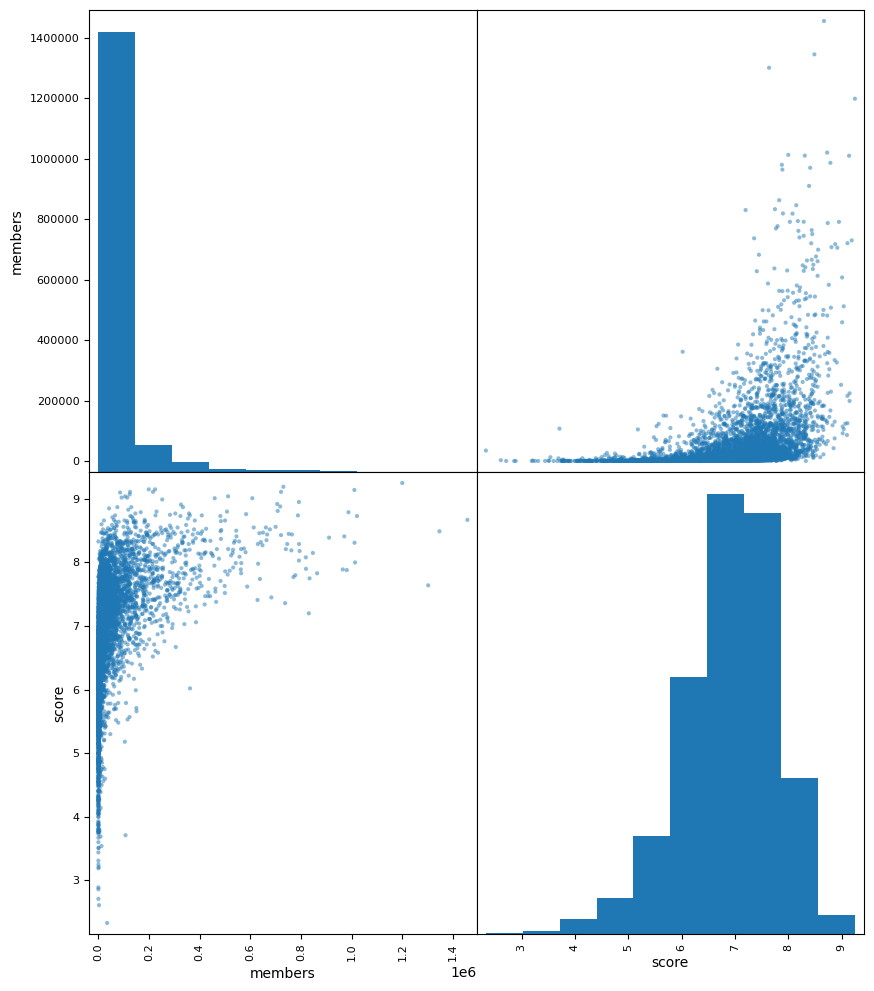

In [11]:
#Normal check of relevant features

x_cols = list(predictors['Features']) + ['score']
pd.plotting.scatter_matrix(anime[x_cols], figsize=(10, 12))
plt.show()

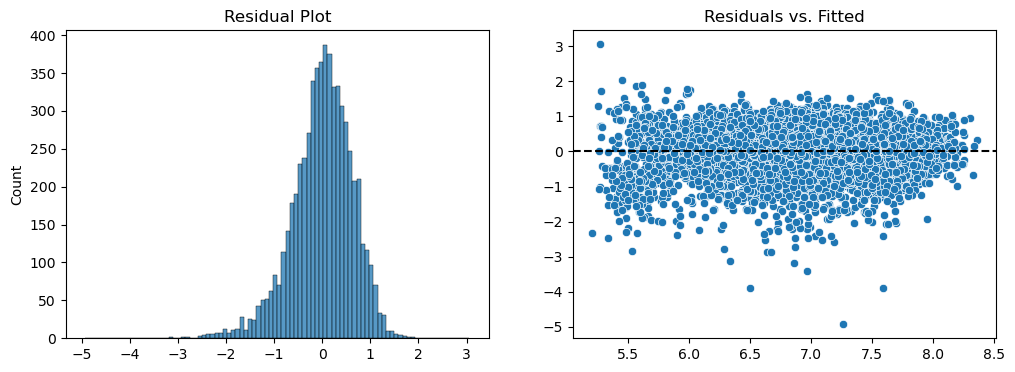

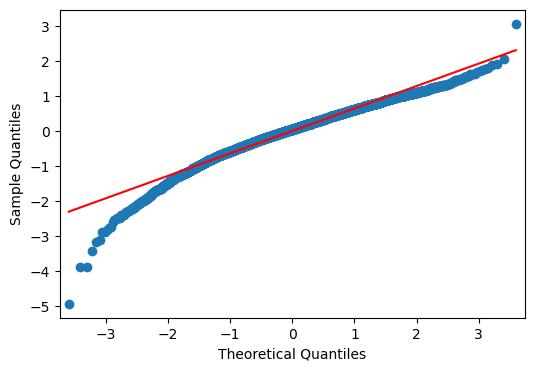

In [12]:
#Taking the log of scored_by and rechecking

anime['members'] = np.log(anime['members'])

#Normality and homoscedacity check
# Fit simple linear regression model
model = smf.ols('score ~ ' + ' + '.join(predictors['Features']), data=anime).fit()

#Residual plot
resid = model.resid
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
sns.histplot(resid, ax=ax1)
ax1.set_title('Residual Plot')
#Scatter Plot
sns.scatterplot(x=model.predict(), y=resid, ax=ax2)
ax2.axhline(0, color='k', linestyle='--')
ax2.set_title('Residuals vs. Fitted')
plt.show()
#QQ plot
fig, ax = plt.subplots(figsize=(6,4))
sm.qqplot(resid, line='s', ax=ax)
plt.show()

In [13]:
#running multiple regression on relevant features
#"relevant features" ended up being only scored_by but that's fine

outcome = 'score'
pred_sum = '+'.join(predictors["Features"])
formula = outcome + '~' + pred_sum

model = ols(formula=formula, data=anime).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     5730.
Date:                Wed, 01 Mar 2023   Prob (F-statistic):               0.00
Time:                        20:28:15   Log-Likelihood:                -5993.2
No. Observations:                6151   AIC:                         1.199e+04
Df Residuals:                    6149   BIC:                         1.200e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.2073      0.036    115.478      0.000       4.136       4.279
members        0.2923      0.004     75.698      0.000       0.285       0.300
==============================================================================
Omnibus:                      768.373   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1714.301
Skew:                          -0.750   Prob(JB):                         0.00
Kurtosis:                       5.107   Cond. No.                         42.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Mean MSE: 0.4113
Std. Dev. of MSE: 0.0249
Intercept: [4.20890272]
Slope: [0.29235258]


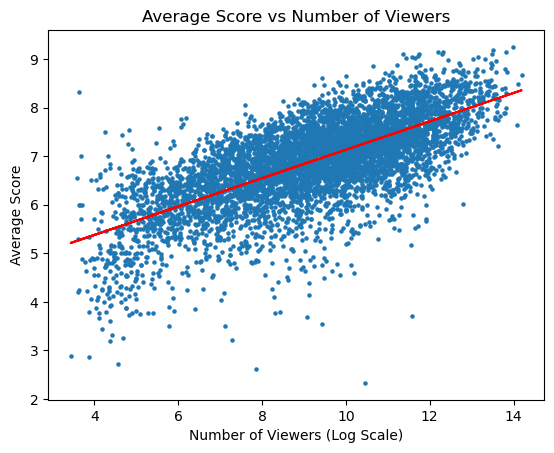

In [14]:
#Running linear regression analysis on scored_by and making a graph

# Extract the "scored_by" and "score" columns as X and y
X = anime["members"].values.reshape(-1, 1)
y = anime["score"].values.reshape(-1, 1)

# Initialize the linear regression model
model = LinearRegression()

# Set up the KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = []

# Loop over the folds
for train_index, test_index in kf.split(X):
    # Split the data into training and test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Predict on the test data and calculate mean squared error
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

# Print the mean and standard deviation of the mean squared error
print("Mean MSE:", round(sum(mse_scores)/len(mse_scores), 4))
print("Std. Dev. of MSE:", round(np.std(mse_scores), 4))

# Print the model coefficients
print("Intercept:", model.intercept_)
print("Slope:", model.coef_[0])

# Plot the data points and regression line
plt.scatter(X, y, s=5)
plt.plot(X, model.predict(X), color="red")
plt.title('Average Score vs Number of Viewers')
plt.xlabel("Number of Viewers (Log Scale)")
plt.ylabel("Average Score")
plt.show()


In [15]:
#Making dummies for categorical values

#First converting the categorical columns into lists

# Define a pattern to extract words from each category
pattern = re.compile(r'[a-zA-Z0-9\- ]+')

# Modify the 'studio', 'genre', 'type', and 'source' columns using regular expressions
anime['studio'] = anime['studio'].apply(lambda x: [word.strip().title() for word in pattern.findall(x) if len(word.strip()) > 1])
anime['genre'] = anime['genre'].apply(lambda x: [word.strip().title() for word in pattern.findall(x) if len(word.strip()) > 1])
anime['type'] = anime['type'].apply(lambda x: [word.strip().title() for word in pattern.findall(x) if len(word.strip()) > 1])
anime['source'] = anime['source'].apply(lambda x: [word.strip().title() for word in pattern.findall(x) if len(word.strip()) > 1])

# Create dummy variables for the modified columns
anime_studio_dummies = anime['studio'].apply(lambda x: '|'.join(x)).str.get_dummies()
anime_genre_dummies = anime['genre'].apply(lambda x: '|'.join(x)).str.get_dummies()
anime_type_dummies = anime['type'].apply(lambda x: '|'.join(x)).str.get_dummies()
anime_source_dummies = anime['source'].apply(lambda x: '|'.join(x)).str.get_dummies()

# Replace spaces with underscores in column names
anime_studio_dummies.columns = anime_studio_dummies.columns.str.replace(' ', '_')
anime_genre_dummies.columns = anime_genre_dummies.columns.str.replace(' ', '_')
anime_type_dummies.columns = anime_type_dummies.columns.str.replace(' ', '_')
anime_source_dummies.columns = anime_source_dummies.columns.str.replace(' ', '_')

In [16]:
#Running multiple regression analysis on genres

# Set the dependent variable 'score' and drop the first column of the dataframe to avoid dummy variable trap
y = anime['score']
X = anime_genre_dummies.iloc[:, 1:]

# Add a constant column to the predictor variables
#X = sm.add_constant(X)

# Fit the multiple regression model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  score   R-squared (uncentered):                   0.874
Model:                            OLS   Adj. R-squared (uncentered):              0.873
Method:                 Least Squares   F-statistic:                              1085.
Date:                Wed, 01 Mar 2023   Prob (F-statistic):                        0.00
Time:                        20:28:16   Log-Likelihood:                         -14288.
No. Observations:                6151   AIC:                                  2.865e+04
Df Residuals:                    6112   BIC:                                  2.892e+04
Df Model:                          39                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

/var/folders/3l/csf1hx2d4x9306d48st_8n700000gn/T/ipykernel_50858/2730547821.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_scores_by_genre = anime_exploded.groupby('genre')['score', 'members'].mean()


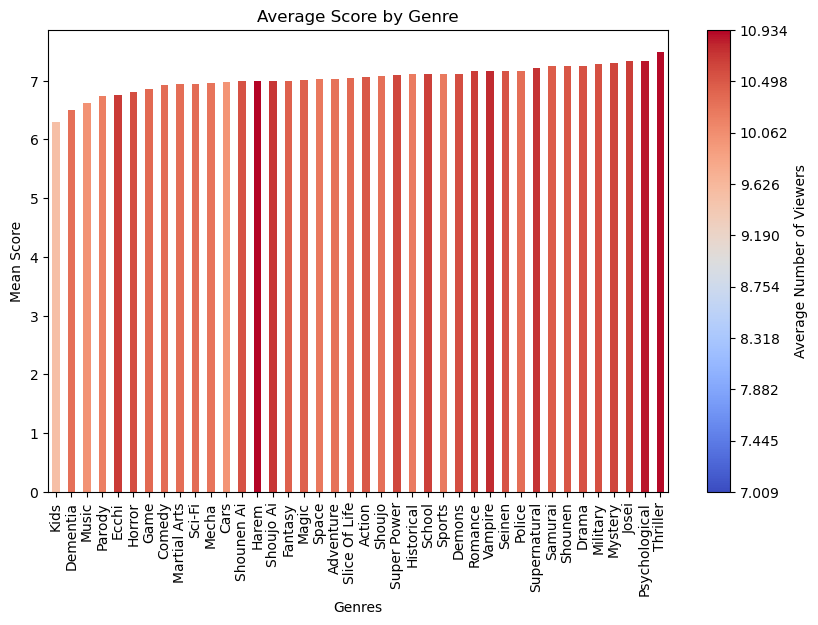

In [17]:
#Making a bar chart of the average score vs genres, coloured by average number of scores

# Explode the genres column to create a new row for each genre in the list
anime_exploded = anime.explode('genre')

# Group the data by genre and calculate the mean score and scored by for each genre
mean_scores_by_genre = anime_exploded.groupby('genre')['score', 'members'].mean()

# Sort the mean scores in ascending order
mean_scores_by_genre = mean_scores_by_genre.sort_values('score')

# Define a colormap
cmap = plt.cm.get_cmap('coolwarm')

# Create a bar plot of the mean scores
ax = mean_scores_by_genre['score'].plot(kind='bar', figsize=(10, 6), color=cmap(mean_scores_by_genre['members']/mean_scores_by_genre['members'].max()))

# Add labels and a title to the plot
plt.xlabel('Genres')
plt.ylabel('Mean Score')
plt.title('Average Score by Genre')

# Add a colorbar to the plot
smplot = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=mean_scores_by_genre['members'].min(), vmax=mean_scores_by_genre['members'].max()))
smplot.set_array([])  # Remove colorbar's axes
cbar = plt.colorbar(smplot, ticks=np.linspace(mean_scores_by_genre['members'].min(), mean_scores_by_genre['members'].max(), 10), ax=ax)
cbar.ax.set_ylabel('Average Number of Viewers')

plt.show()

In [18]:
#Repeating for anime sources

# Set the dependent variable 'score' and drop the first column of the dataframe to avoid dummy variable trap
y = anime['score']
X = anime_source_dummies.iloc[:, 1:]

# Add a constant column to the predictor variables
#X = sm.add_constant(X)

# Fit the multiple regression model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  score   R-squared (uncentered):                   0.955
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                              9376.
Date:                Wed, 01 Mar 2023   Prob (F-statistic):                        0.00
Time:                        20:28:16   Log-Likelihood:                         -11095.
No. Observations:                6151   AIC:                                  2.222e+04
Df Residuals:                    6137   BIC:                                  2.231e+04
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

/var/folders/3l/csf1hx2d4x9306d48st_8n700000gn/T/ipykernel_50858/1681968551.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_scores_by_source = anime_exploded.groupby('source')['score', 'members'].mean()


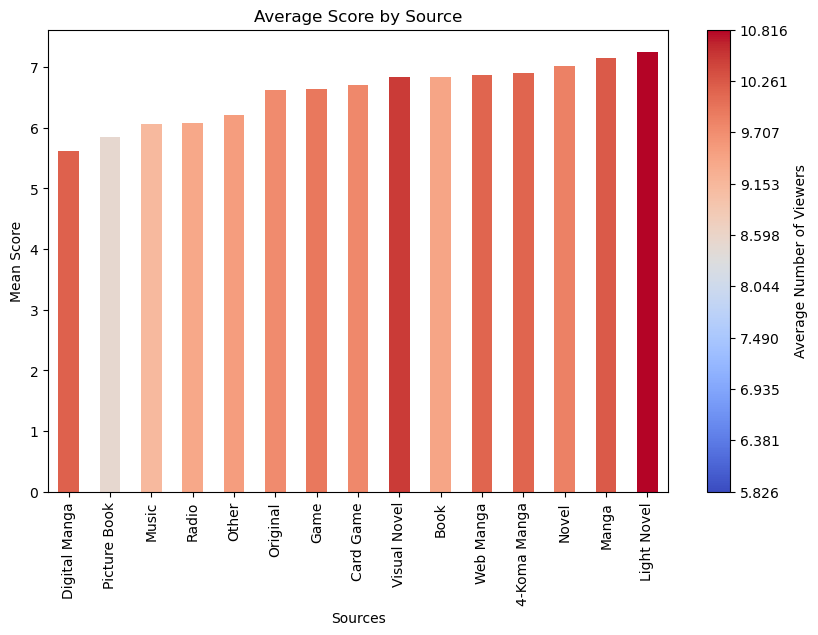

In [19]:
# Explode the sources column to create a new row for each source in the list
anime_exploded = anime.explode('source')

# Group the data by source and calculate the mean score and scored by for each source
mean_scores_by_source = anime_exploded.groupby('source')['score', 'members'].mean()

# Sort the mean scores in ascending order
mean_scores_by_source = mean_scores_by_source.sort_values('score')

# Define a colormap
cmap = plt.cm.get_cmap('coolwarm')

# Create a bar plot of the mean scores
ax = mean_scores_by_source['score'].plot(kind='bar', figsize=(10, 6), color=cmap(mean_scores_by_source['members']/mean_scores_by_source['members'].max()))

# Add labels and a title to the plot
plt.xlabel('Sources')
plt.ylabel('Mean Score')
plt.title('Average Score by Source')

# Add a colorbar to the plot
smplot = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=mean_scores_by_source['members'].min(), vmax=mean_scores_by_source['members'].max()))
smplot.set_array([])  # Remove colorbar's axes
cbar = plt.colorbar(smplot, ticks=np.linspace(mean_scores_by_source['members'].min(), mean_scores_by_source['members'].max(), 10), ax=ax)
cbar.ax.set_ylabel('Average Number of Viewers')

plt.show()

In [20]:
#Repeating for anime types

# Set the dependent variable 'score' and drop the first column of the dataframe to avoid dummy variable trap
y = anime['score']
X = anime_type_dummies.iloc[:, 1:]

# Add a constant column to the predictor variables
#X = sm.add_constant(X)

# Fit the multiple regression model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  score   R-squared (uncentered):                   0.834
Model:                            OLS   Adj. R-squared (uncentered):              0.834
Method:                 Least Squares   F-statistic:                              6162.
Date:                Wed, 01 Mar 2023   Prob (F-statistic):                        0.00
Time:                        20:28:16   Log-Likelihood:                         -15138.
No. Observations:                6151   AIC:                                  3.029e+04
Df Residuals:                    6146   BIC:                                  3.032e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/var/folders/3l/csf1hx2d4x9306d48st_8n700000gn/T/ipykernel_50858/14216106.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_scores_by_type = anime_exploded.groupby('type')['score', 'members'].mean()


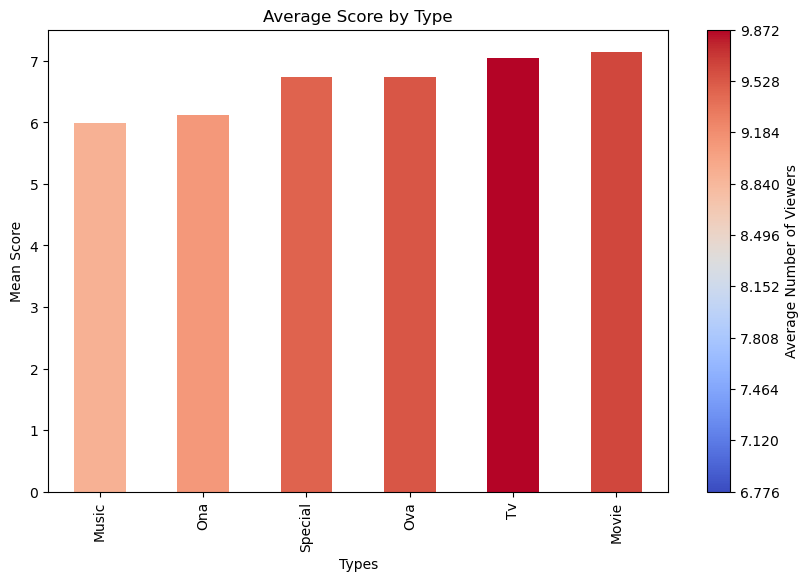

In [21]:
# Explode the types column to create a new row for each type in the list
anime_exploded = anime.explode('type')

# Group the data by type and calculate the mean score and scored by for each type
mean_scores_by_type = anime_exploded.groupby('type')['score', 'members'].mean()

# Sort the mean scores in ascending order
mean_scores_by_type = mean_scores_by_type.sort_values('score')

# Define a colormap
cmap = plt.cm.get_cmap('coolwarm')

# Create a bar plot of the mean scores
ax = mean_scores_by_type['score'].plot(kind='bar', figsize=(10, 6), color=cmap(mean_scores_by_type['members']/mean_scores_by_type['members'].max()))

# Add labels and a title to the plot
plt.xlabel('Types')
plt.ylabel('Mean Score')
plt.title('Average Score by Type')

# Add a colorbar to the plot
smplot = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=mean_scores_by_type['members'].min(), vmax=mean_scores_by_type['members'].max()))
smplot.set_array([])  # Remove colorbar's axes
cbar = plt.colorbar(smplot, ticks=np.linspace(mean_scores_by_type['members'].min(), mean_scores_by_type['members'].max(), 10), ax=ax)
cbar.ax.set_ylabel('Average Number of Viewers')

plt.show()